### Imports 

In [1]:
import pickle as pkl
import lxml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import importlib
import time

from tensorflow.keras.datasets import imdb
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add, ZeroPadding1D


importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [2]:
tqdm.pandas()

In [3]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

### Helper Functions / Classes 

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    #ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [24]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        plt.legend()
        plt.show()
        
        plt.hist(predictions, label = 'Prediction Distribution')
        plt.legend()
        plt.show()    
        
        plt.hist(actual, label = 'Actual Distribution')
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

### Data 

In [12]:
chunk_size = 8 * 100

drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = chunk_size, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


print ("Reading data - chunk size : " + str(chunk_size) )
start = time.time()
drugbank = drugbank_reader.__next__()
end = time.time()
print ("Data read complete : " + str(end - start) + "s")


Reading data - chunk size : 800
Data read complete : 6.573439121246338s


In [ ]:
compressed_db = drugbank[['drug_id', 'gene_id']]

### Models

#### 1D Adaptation Of ResNet-50

(Incorrect At The Moment)

In [13]:
def identity_block(X, kernel_size, filters):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    # Component 1
    X = Conv1D(filters = F1, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 2 
    X = Conv1D(filters = F2, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 3 
    X = Conv1D(filters = F3, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

In [14]:
def convolutional_block(X, kernel_size, filters, s = 2):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    ## Main Path 
    # Component 1 
    X = Conv1D(filters = F1, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 2
    X = Conv1D(filters = F2, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 3
    X = Conv1D(filters = F3, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    ## Shortcut Path
    X_shortcut = Conv1D(filters = F3, kernel_size = 16, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [15]:
def ResNet_1D(input_shape = (30723, 1)):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv1D(filters = 64, kernel_size = 16, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform())(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Stage 2 - 1 Conv Block & 2 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [64, 64, 128], s = 1)
    X = identity_block(X, kernel_size = 1, filters = [64, 64, 128])
    X = identity_block(X, kernel_size = 1, filters = [64, 64, 128])
    
    # Stage 3 - 1 Conv Block & 3 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    
    # Stage 4 - 1 Conv Block & 5 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    
    # Stage 5 - 1 Conv Block & 2 Identity Blocks 
    X = convolutional_block(X, kernel_size = 16, filters = [512, 512, 1024])
    X = identity_block(X, kernel_size = 1, filters = [512, 512, 1024])
    X = identity_block(X, kernel_size = 1, filters = [512, 512, 1024])
    
    
    X = GlobalAveragePooling1D()(X)
    X = Flatten()(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model
    

#### 1D Adaptation Of VGG 16 

In [16]:
def OneDimensional_VGG(input_shape = (30723, 1)):
    
    X_input = Input(input_shape)
    
    # Convolution Block 1
    X = Conv1D(filters = 64, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB1-C1')(X_input)
    X = Conv1D(filters = 64, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB1-C2')(X)
    X = BatchNormalization(name = 'CB1-BN1')(X)
    X = AveragePooling1D(name = 'CB1-P1')(X)
    X = Dropout(0.4, name = 'CB1-DO1')(X)
    
    # Convolution Block 2
    X = Conv1D(filters = 128, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB2-C1')(X)
    X = Conv1D(filters = 128, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB2-C2')(X)
    X = BatchNormalization(name = 'CB2-BN1')(X)
    X = AveragePooling1D(name = 'CB2-P1')(X)
    X = Dropout(0.4, name = 'CB2-DO1')(X)

    # Convolution Block 3
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB3-C1')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB3-ZP1')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB3-C2')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB3-ZP2')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB3-C3')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB3-ZP3')(X)
    X = BatchNormalization(name = 'CB3-BN1')(X)
    X = AveragePooling1D(name = 'CB3-P1')(X)
    X = Dropout(0.4, name = 'CB3-DO1')(X)
    
    # Convolution Block 4
    X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB4-C1')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB4-ZP1')(X)
    X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB4-C2')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB4-ZP2')(X)
    X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB4-C3')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB4-ZP3')(X)
    X = BatchNormalization(name = 'CB4-BN1')(X)
    X = AveragePooling1D(name = 'CB4-P1')(X)
    X = Dropout(0.4, name = 'CB4-DO1')(X)
    
    # Convolution Block 5
    X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB5-C1')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB5-ZP1')(X)
    X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB5-C2')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB5-ZP2')(X)
    X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB5-C3')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB5-ZP3')(X)
    X = BatchNormalization(name = 'CB5-BN1')(X)
    X = AveragePooling1D(name = 'CB5-P1')(X)
    X = Dropout(0.4, name = 'CB5-DO1')(X)
    
    X = GlobalAveragePooling1D(name = 'GP-1')(X)
    X = Flatten(name = 'Flat-1')(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)

    return model

#### 1D VGG - No Padding 

In [17]:
def VGG_16(input_shape = (30723, 1)):

    X_input = Input(input_shape)
    
    # Convolution Block 1
    X = Conv1D(filters = 64, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-1-ConvLayer-1')(X_input)
    X = Conv1D(filters = 64, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-1-ConvLayer-2')(X)
    X = BatchNormalization(name = 'ConvBlock-1-BatchNorm-1')(X)
    X = AveragePooling1D(name = 'ConvBlock-1-AvgPool-1')(X)
    
    # Convolution Block 2
    X = Conv1D(filters = 128, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-2-ConvLayer-1')(X)
    X = Conv1D(filters = 128, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-2-ConvLayer-2')(X)
    X = BatchNormalization(name = 'ConvBlock-2-BatchNorm-1')(X)
    # Test Drop Out
    X = Dropout(0.4, name = 'ConvBlock-2-DropOut-1')(X)

    # Convolution Block 3
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-3-ConvLayer-1')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-3-ConvLayer-2')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-3-ConvLayer-3')(X)
    X = BatchNormalization(name = 'ConvBlock-3-BatchNorm-1')(X)
    # Test Drop Out
    X = Dropout(0.5, name = 'ConvBlock-3-DropOut-1')(X)

#     # Convolution Block 4
#     X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-4-ConvLayer-1')(X)
#     X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-4-ConvLayer-2')(X)
#     X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-4-ConvLayer-3')(X)
#     X = BatchNormalization(name = 'ConvBlock-4-BatchNorm-1')(X)
#     # Test Drop Out
#     X = Dropout(0.7, name = 'ConvBlock-4-DropOut-1')(X)

#     # Convolution Block 5
#     X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-5-ConvLayer-1')(X)
#     X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-5-ConvLayer-2')(X)
#     X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', name = 'ConvBlock-5-ConvLayer-3')(X)
#     X = BatchNormalization(name = 'ConvBlock-5-BatchNorm-1')(X)
#     # Test Drop Out
#     X = Dropout(0.7, name = 'ConvBlock-5-DropOut-1')(X)
    
    X = GlobalAveragePooling1D(name = 'ConvBlock-1-GlobalPool-1')(X)
    X = Flatten()(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)

    model = Model(inputs = X_input, outputs = X)

    return model

In [18]:
model = OneDimensional_VGG()

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30723, 1)          0         
_________________________________________________________________
CB1-C1 (Conv1D)              (None, 30723, 64)         192       
_________________________________________________________________
CB1-C2 (Conv1D)              (None, 30723, 64)         8256      
_________________________________________________________________
CB1-BN1 (BatchNormalization) (None, 30723, 64)         256       
_________________________________________________________________
CB1-P1 (AveragePooling1D)    (None, 15361, 64)         0         
_________________________________________________________________
CB1-DO1 (Dropout)            (None, 15361, 64)         0         
_________________________________________________________________
CB2-C1 (Conv1D)              (None, 15361, 128)        16512     
__________

In [20]:
model = VGG_16()

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30723, 1)          0         
_________________________________________________________________
ConvBlock-1-ConvLayer-1 (Con (None, 15361, 64)         192       
_________________________________________________________________
ConvBlock-1-ConvLayer-2 (Con (None, 7680, 64)          8256      
_________________________________________________________________
ConvBlock-1-BatchNorm-1 (Bat (None, 7680, 64)          256       
_________________________________________________________________
ConvBlock-1-AvgPool-1 (Avera (None, 3840, 64)          0         
_________________________________________________________________
ConvBlock-2-ConvLayer-1 (Con (None, 1920, 128)         16512     
_________________________________________________________________
ConvBlock-2-ConvLayer-2 (Con (None, 960, 128)          32896     
__________

### Train

In [22]:
model_optimizer = tensorflow.keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
batch_size = 8
epochs = 4
model.compile(loss = 'binary_crossentropy', optimizer = model_optimizer, metrics = ['binary_accuracy'])


In [27]:
print ("CSV Chunk Size : " + str(chunk_size))
print ("Training Bacth Size : " + str(batch_size))
print ("Epochs : " + str(epochs))

global_history = []
global_val_history = []
predictions = []
actual = []

with open('data/gene_encoder.pkl', 'rb') as f:
    label_encoder = pkl.load(f)
    

for drugbank in tqdm(drugbank_reader):
    
    
    print('Reading chunk from file..')
    print('Sampling..')
    train_df_inter, test_df = train_test_split(drugbank)

    ##FORCE TRAIN NEGATIVE SAMPLES ON LOW EPOCH
    train_df = pd.DataFrame()
    
    if len(train_df_inter[train_df_inter['Y'] == 0]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 0].sample(frac = 1.0))
    
    if len(train_df_inter[train_df_inter['Y'] == 1]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 1].sample(frac = 1.0))

    
    print('Padding..') 
    X_0 = np.array(list(train_df['target_gene_encoded_padded']))
    X_1 = np.array(list(train_df['drug_fingerprint_encoded_padded']))
    Y   = np.array(list(train_df['Y']))
    

    X_0_test = np.array(list(test_df['target_gene_encoded_padded']))
    X_1_test = np.array(list(test_df['drug_fingerprint_encoded_padded']))
        
    Y_test   = np.array(list(test_df['Y']))
    

    X_0 = X_0.astype(int) + 1
    X_1 = X_1.astype(int) + 1
    Y   = Y.astype(int)

    X_0_test = X_0_test.astype(int) + 1
    X_1_test = X_1_test.astype(int) + 1
    Y_test   = Y_test.astype(int)
    

    X_0 = np.hstack((X_0, X_1))
    X_0_test = np.hstack((X_0_test, X_1_test))

    print('Modelling..')

    
    history = model.fit(X_0[..., np.newaxis], Y,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=[plot_losses],
                          class_weight = {0: 1., 1: 5},
                          validation_data=(X_0_test[..., np.newaxis], Y_test), verbose = 2)


    actual.extend(Y.tolist())
    predictions.extend(model.predict(X_0_test[..., np.newaxis]).ravel())
    
    global_val_history.extend(history.history['val_binary_accuracy'])
    global_history.extend(history.history['binary_accuracy'])


    

CSV Chunk Size : 800
Training Bacth Size : 8
Epochs : 4


Reading chunk from file..
Sampling..
Padding..
Modelling..


ValueError: Invalid argument "class_weight" passed to K.function with TensorFlow backend

In [ ]:
model.save('models/1D-VGG-NoPadding.model')

### Test

In [30]:
iterator = True


if iterator == True:
    
    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})
if iterator == False:

    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

In [31]:
drugbank_test = drugbank_reader.__next__()

In [33]:

print('Padding..') 
X_0 = np.array(list(drugbank_test['target_gene_encoded_padded']))
X_1 = np.array(list(drugbank_test['drug_fingerprint_encoded_padded']))
Y   = np.array(list(drugbank_test['Y']))


X_0_test = np.array(list(drugbank_test['target_gene_encoded_padded']))
X_1_test = np.array(list(drugbank_test['drug_fingerprint_encoded_padded']))

Y_test   = np.array(list(drugbank_test['Y']))

print(X_0.shape)
print(X_1.shape)

print(X_0_test.shape)
print(X_1_test.shape)


X_0 = X_0.astype(int) + 1
X_1 = X_1.astype(int) + 1
Y   = Y.astype(int)

X_0_test = X_0_test.astype(int) + 1
X_1_test = X_1_test.astype(int) + 1
Y_test   = Y_test.astype(int)

print(X_0.shape)
print(X_1.shape)

print(X_0_test.shape)
print(X_1_test.shape)


X_0 = np.hstack((X_0, X_1))
X_0_test = np.hstack((X_0_test, X_1_test))



Y_test = model.predict(X_0[..., np.newaxis])

Padding..
(500, 21222)
(500, 9501)
(500, 21222)
(500, 9501)
(500, 21222)
(500, 9501)
(500, 21222)
(500, 9501)


(array([  2.,   0.,   0.,   1.,   4.,  52., 183., 195.,  58.,   5.]),
 array([0.99945825, 0.99947464, 0.99949102, 0.99950741, 0.99952379,
        0.99954018, 0.99955657, 0.99957295, 0.99958934, 0.99960572,
        0.99962211]),
 <a list of 10 Patch objects>)

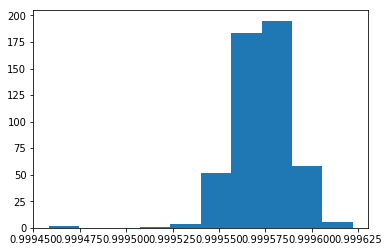

In [34]:
plt.hist(Y_test)

In [35]:
Y_test = [1 if (i > 0.5) else 0 for i in Y_test ]
cm = confusion_matrix(Y_test, Y)

In [36]:
cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[nan, nan],
       [ 1.,  0.]])

In [37]:
f1_score(Y_test, Y)

/miniconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

Confusion matrix, without normalization
[[  0 500]
 [  0   0]]
Normalized confusion matrix
[[ 0.  1.]
 [nan nan]]


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


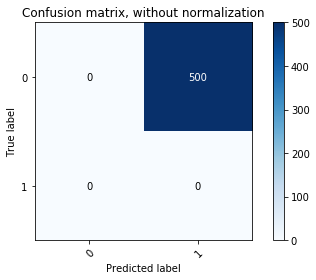

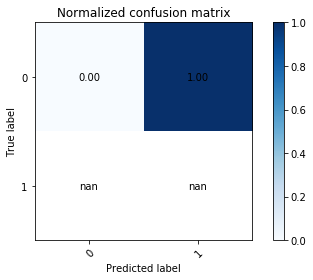

In [38]:
plot_confusion_matrix(Y, Y_test, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y, Y_test, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

In [41]:
print(classification_report(Y, Y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       500
          1       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00       500



/miniconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/miniconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
